## Dataset Description
The dataset is made up of tab-separated files containing Rotten Tomatoes phrases. 
The train/test split has been kept for benchmarking purposes, but the sentences have been shuffled from their original order. The Stanford parser has broken each sentence down into many phrases. 
Each phrase has its own PhraseId. SentenceIds are assigned to each sentence. Repeated phrases (such as short/common words) are only included in the data once.
The sentiment labels are:

0: negative
1: somewhat negative
2: neutral
3: somewhat positive
4: positive

# Import Packages

In [1]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [14]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation
from nltk.corpus import stopwords
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow import keras 
from tensorflow.keras.preprocessing.sequence import pad_sequences  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Embedding, Bidirectional, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.utils import shuffle, resample
import spacy
from wordcloud import WordCloud

# Load File

In [4]:
train=pd.read_csv("train.tsv", sep="\t")
test=pd.read_csv("test.tsv", sep="\t")
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
data = train[['Phrase','Sentiment']].copy()
data

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2
...,...,...
156055,Hearst 's,2
156056,forced avuncular chortles,1
156057,avuncular chortles,3
156058,avuncular,2


In [22]:
import re
import spacy

sp = spacy.load('en_core_web_sm')
stopwords = sp.Defaults.stop_words
stopwords |= {"movie","movies","film","story","character","characters","comedy"}
# print(stopwords)
# stopwords.remove('not')

def remove_stopwords(text):
    text_tokens = text.split(" ")
    text_tokens_filtered= [word for word in text_tokens if not word in stopwords]
    return (" ").join(text_tokens_filtered)

def clean(text):
    text = remove_stopwords(text.lower())        # Removing stopwords decreased accuracies, therefore we did not use!!!
    text = re.sub(r'@|#', r'', text.lower())     # Returns a string with @-symbols and hashtags removed.
    text = re.sub(r'http.*', r'', text.lower())  # Returns a string with any websites starting with 'http.' removed.
    return ' '.join(re.findall(r'\w+', text.lower())) # Returns a string with only English unicode word characters ([a-zA-Z0-9_]).

data['Phrase'] = data['Phrase'].apply(lambda x: clean(x))
data

,Phrase,Sentiment,data_type
0,george w bush henry kissinger,2,train
1,age wise,2,train
2,potential,2,train
3,practically like themed oscar sweeping franchi...,3,train
4,rarely s title served dire warning,0,val
...,...,...,...
149224,s exactly worth,1,train
149225,welcome accept trials henry kissinger faithful...,3,train
149226,rarely sure,1,train
149227,dialogue,2,train


In [23]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(data.index.values, 
                                                  data.Sentiment.values, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  stratify=data.Sentiment)

# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=y_train)

In [24]:
data['data_type'] = ['not_set']*data.shape[0]
data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'
data.loc[X_test, 'data_type'] = 'test'

data = data.dropna()

In [25]:
# Remove duplicates 
train_set = data[data['data_type'] == 'train'].drop_duplicates(ignore_index=True)
val_set = data[data['data_type'] == 'val'].drop_duplicates(ignore_index=True)
test_set = data[data['data_type'] == 'test'].drop_duplicates(ignore_index=True)

data = pd.concat([train_set, val_set, test_set], ignore_index=True)
data = data.sample(frac=1, random_state=1).reset_index(drop=True)
data

,Phrase,Sentiment,data_type
0,straight hell,2,test
1,old disease week small screen melodramas,1,train
2,cooks conduct low smoky inviting sizzle,2,train
3,n t think thing run dark tunnels fight anonymo...,1,train
4,beautiful cold oddly colorful plain otherworld...,3,train
...,...,...,...
112560,previous responsibility,2,train
112561,ms paltrow employs authenticate british persona,1,val
112562,s howler,3,train
112563,poignancy,2,train


0: negative
1: somewhat negative
2: neutral
3: somewhat positive
4: positive

<AxesSubplot: xlabel='Sentiment'>

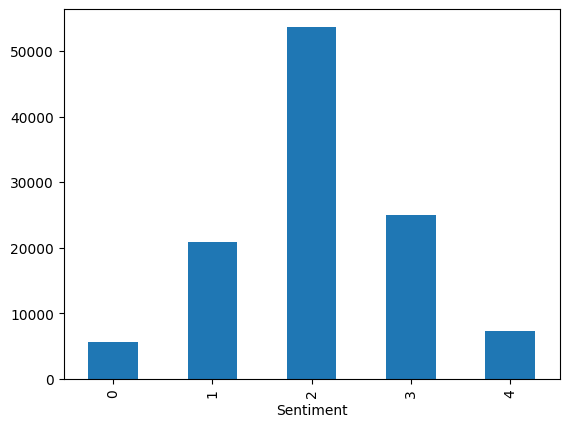

In [26]:
#Shapes
data.groupby("Sentiment").Sentiment.count().plot.bar(ylim=0)

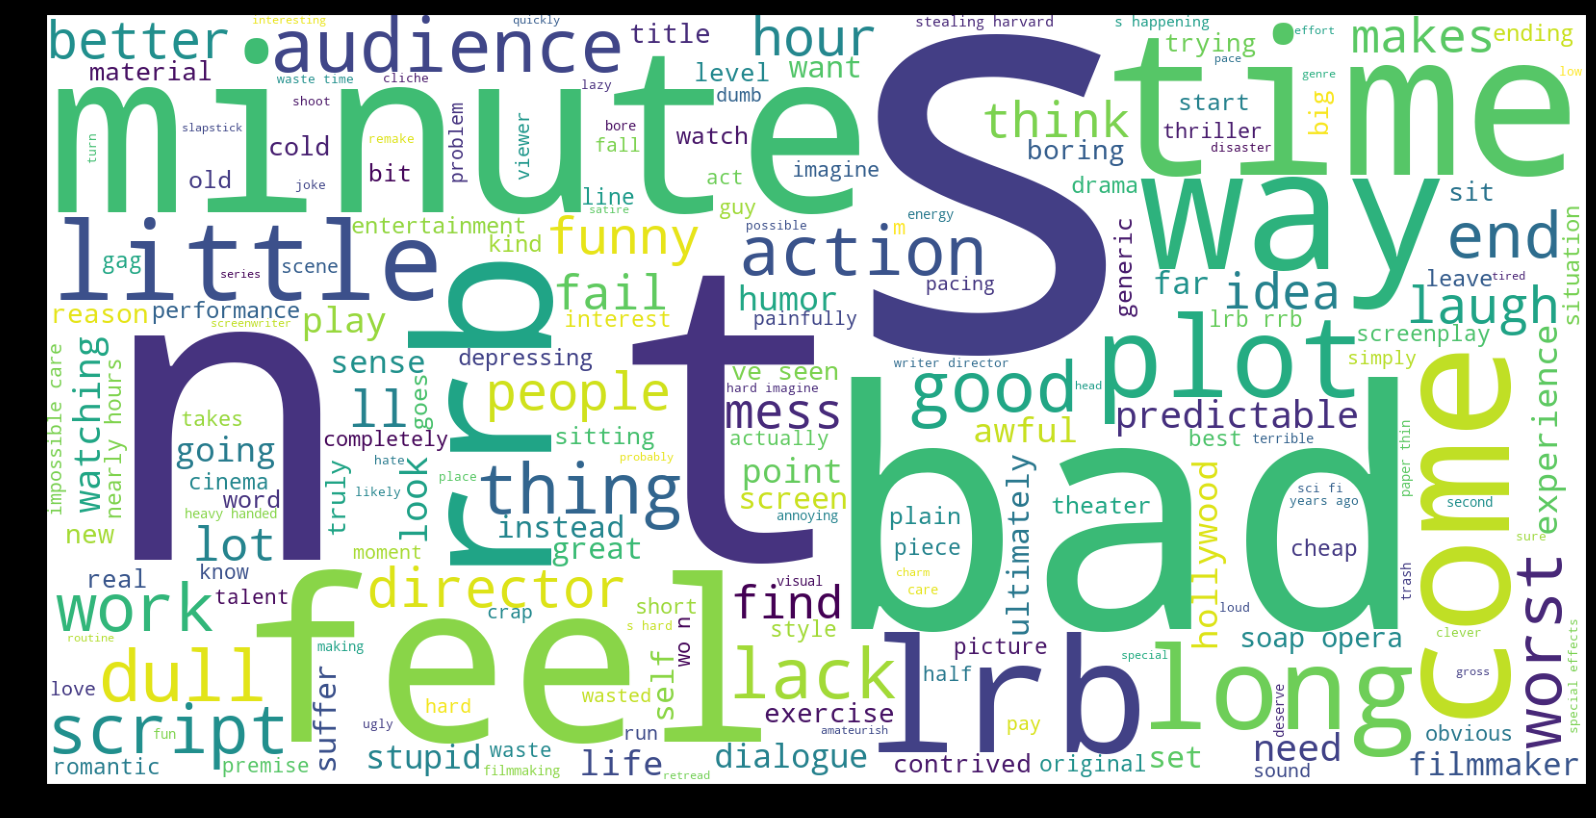

In [27]:
#dtypes
negative = data[data['Sentiment'] == 0]
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(negative.Phrase))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)

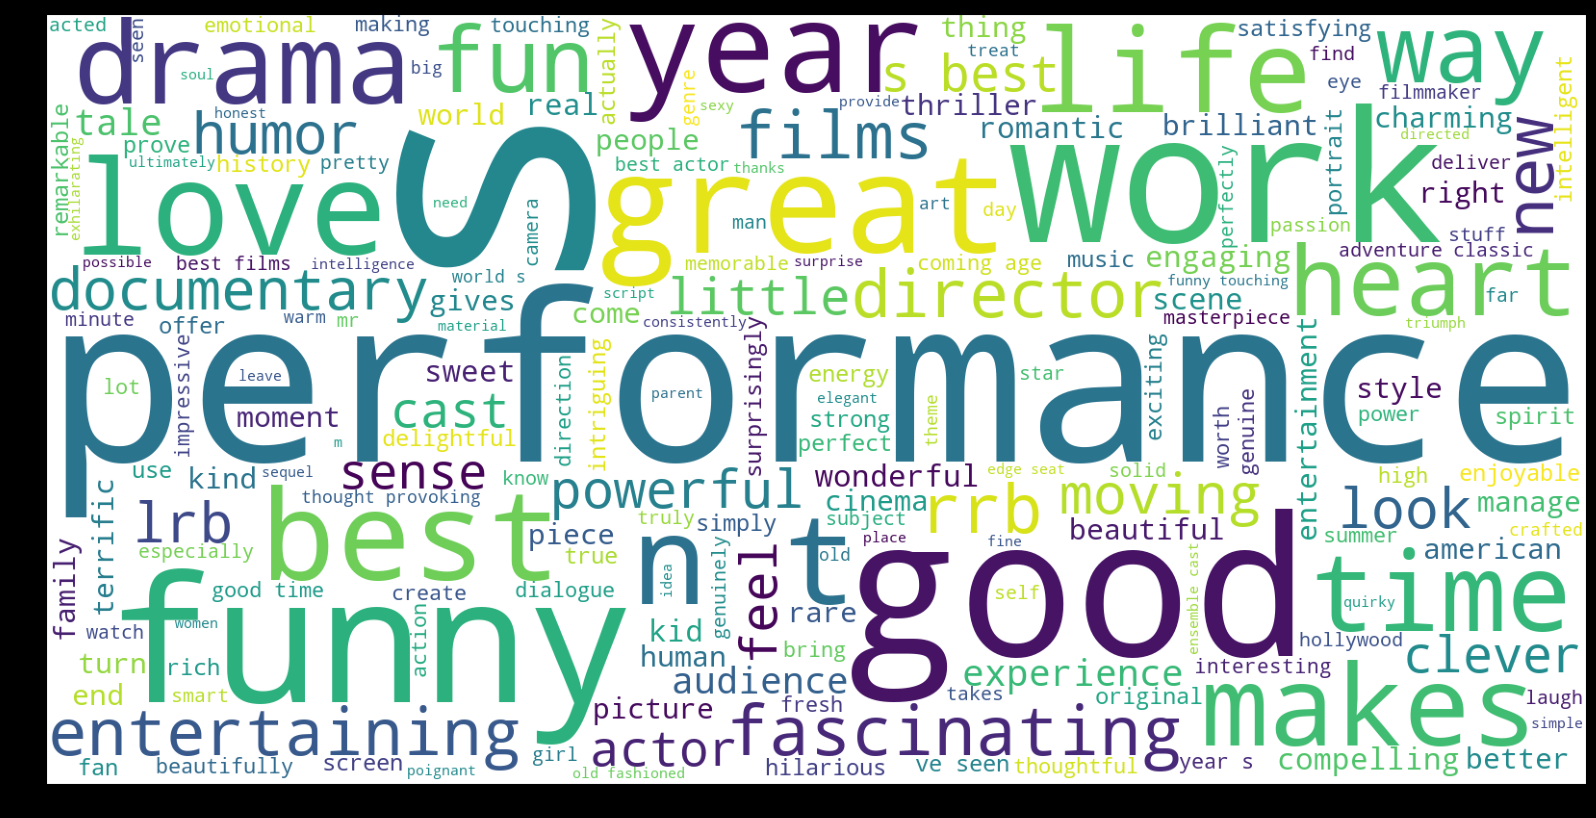

In [28]:
positive = data[data['Sentiment'] == 4]
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(positive.Phrase))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordCloud)